In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import NMF
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Flatten, Dropout, Reshape

In [1]:
df = pd.read_csv('./data/bitcoin2023_t.csv')
print(df)

NameError: name 'pd' is not defined

In [3]:
class PastSampler:
    '''
    Forms training samples for predicting future values from past value
    '''
     
    def __init__(self, N, K, sliding_window = True):
        '''
        Predict K future sample using N previous samples
        '''
        self.K = K
        self.N = N
        self.sliding_window = sliding_window
 
    def transform(self, A):
        M = self.N + self.K     #Number of samples per row (sample + target)
        #indexes
        I = np.arange(M) + np.arange(0, A.shape[0] - M + self.sliding_window, M).reshape(-1, 1)
            
        B = A[I].reshape(-1, M * A.shape[1], A.shape[2])
        ci = self.N * A.shape[1]    #Number of features per sample
        return B[:, :ci], B[:, ci:] #Sample matrix, Target matrix

#data file path
# dfp = 'data/bitcoin2015to2017.csv'
# dfp = 'data/Bitstamp_BTCUSD_1h.csv' # 2018-05-15 to 2023-05-08
dfp = './data/bitcoin2023_t.csv' # 2018-05-15 to 2023-05-08
# [unix, date, symbol, open, high, low, close, Volume BTC, Volume USD]

#Columns of price data to use
columns = ['trade_price']
df = pd.read_csv(dfp)
time_stamps = df['candle_date_time_kst']
df = df.loc[:,columns]
original_df = pd.read_csv(dfp).loc[:,columns]

In [4]:
df

,trade_price
0,36975000
1,36995000
2,37001000
3,37000000
4,37001000
...,...
588858,4215000
588859,4227000
588860,4227000
588861,4227000


In [5]:
time_stamps

0         2023-05-09T14:05:00
1         2023-05-09T14:00:00
2         2023-05-09T13:55:00
3         2023-05-09T13:50:00
4         2023-05-09T13:45:00
                 ...         
588858    2017-09-25T12:20:00
588859    2017-09-25T12:15:00
588860    2017-09-25T12:10:00
588861    2017-09-25T12:05:00
588862    2017-09-25T12:00:00
Name: candle_date_time_kst, Length: 588863, dtype: object

In [6]:
# file_name='bitcoin2015to2017_close.h5'
file_name='bitcoin2017to2023_close.h5'

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
# normalization: 하나씩
for c in columns:
  df[c] = scaler.fit_transform(df[c].values.reshape(-1,1))

# normalization: 전체
# df_normalized = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)
     

In [7]:
#Features are input sample dimensions(channels)
A = np.array(df)[:,None,:]
original_A = np.array(original_df)[:,None,:]
time_stamps = np.array(time_stamps)[:,None,None]
#Make samples of temporal sequences of pricing data (channel)
# NPS, NFS = 24, 1  #Number of past and future samples: 24시간으로 1시간 예측
NPS, NFS = 8, 1
ps = PastSampler(NPS, NFS, sliding_window=True)
B, Y = ps.transform(A)
input_times, output_times = ps.transform(time_stamps)
original_B, original_Y = ps.transform(original_A)

In [8]:
import h5py
with h5py.File(file_name, 'w') as f:
    f.create_dataset("inputs", data = B)
    f.create_dataset('outputs', data = Y)
    f.create_dataset("input_times", data = input_times)
    f.create_dataset('output_times', data = output_times)
    f.create_dataset("original_datas", data=np.array(original_df))
    f.create_dataset('original_inputs',data=original_B)
    f.create_dataset('original_outputs',data=original_Y)

In [9]:
B.shape

(65429, 8, 1)

In [10]:
!pip install imageio

In [11]:
from keras import applications
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dropout, Flatten, Dense, Activation
from keras.callbacks import CSVLogger
import tensorflow as tf
from imageio import imread
import numpy as np
import random
from keras.layers import LSTM
from keras.layers import Conv1D, MaxPooling1D
from keras import backend as K
import keras
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras import optimizers
import h5py
from sklearn.preprocessing import MinMaxScaler
import os
import pandas as pd
# import matplotlib

import matplotlib.pyplot as plt
plt.switch_backend('agg')
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'True'
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = '1'
os.environ['TF_CPP_MIN_LOG_LEVEL']='2'

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

with h5py.File(''.join(['bitcoin2017to2023_close.h5']), 'r') as hf:
    datas = hf['inputs'][()]
    labels = hf['outputs'][()]
    input_times = hf['input_times'][()]
    output_times = hf['output_times'][()]
    original_datas = hf['original_datas'][()]
    original_outputs = hf['original_outputs'][()]

In [12]:
scaler=MinMaxScaler()
#split training validation
training_size = int(0.8* datas.shape[0]) #80%
training_datas = datas[:training_size,:]
training_labels = labels[:training_size,:]
validation_datas = datas[training_size:,:]
validation_labels = labels[training_size:,:]
ground_true = original_outputs[training_size:,:]

In [13]:
step_size = datas.shape[1]
batch_size= 32
nb_features = datas.shape[2]
epochs = 100

In [14]:
#build model
model = Sequential()
model.add(Conv1D(activation="relu", input_shape=(step_size, nb_features), strides=3	, filters=8, kernel_size=8))
# model.add(Dropout(0.05))
model.add(Conv1D( strides=4, padding='same', filters=nb_features, kernel_size=8))
model.add(LSTM(100, input_shape=(None, 1), activation='relu'))
model.add(Dense(1))

model.compile(loss='mse', optimizer='adam')

In [15]:
output_file_name = '2017to2023_BTC-KRW'

history = model.fit(
    training_datas,
    training_labels,
    verbose=1,
    batch_size=batch_size,
    validation_data=(validation_datas, validation_labels),
    epochs=epochs,
    callbacks=[
        CSVLogger(output_file_name+'.csv', append=True),
        ModelCheckpoint('weights_2017to2023/'+output_file_name+'-{epoch:02d}-{val_loss:.5f}.hdf5', monitor='val_loss', verbose=1, mode='min')
    ]
)


Epoch 1/100
1627/1636 [============================>.] - ETA: 0s - loss: 0.0061
Epoch 1: saving model to weights_2017to2023\2017to2023_BTC-KRW-01-0.00000.hdf5
1636/1636 [==============================] - 4s 2ms/step - loss: 0.0060 - val_loss: 1.5599e-06
Epoch 2/100
1600/1636 [============================>.] - ETA: 0s - loss: 3.4829e-06
Epoch 2: saving model to weights_2017to2023\2017to2023_BTC-KRW-02-0.00000.hdf5
1636/1636 [==============================] - 2s 2ms/step - loss: 3.4783e-06 - val_loss: 1.3878e-06
Epoch 3/100
1616/1636 [============================>.] - ETA: 0s - loss: 3.8006e-06
Epoch 3: saving model to weights_2017to2023\2017to2023_BTC-KRW-03-0.00000.hdf5
1636/1636 [==============================] - 2s 1ms/step - loss: 3.7889e-06 - val_loss: 1.3561e-06
Epoch 4/100
1624/1636 [============================>.] - ETA: 0s - loss: 4.3419e-06
Epoch 4: saving model to weights_2017to2023\2017to2023_BTC-KRW-04-0.00000.hdf5
1636/1636 [==============================] - 2s 1ms/step - 

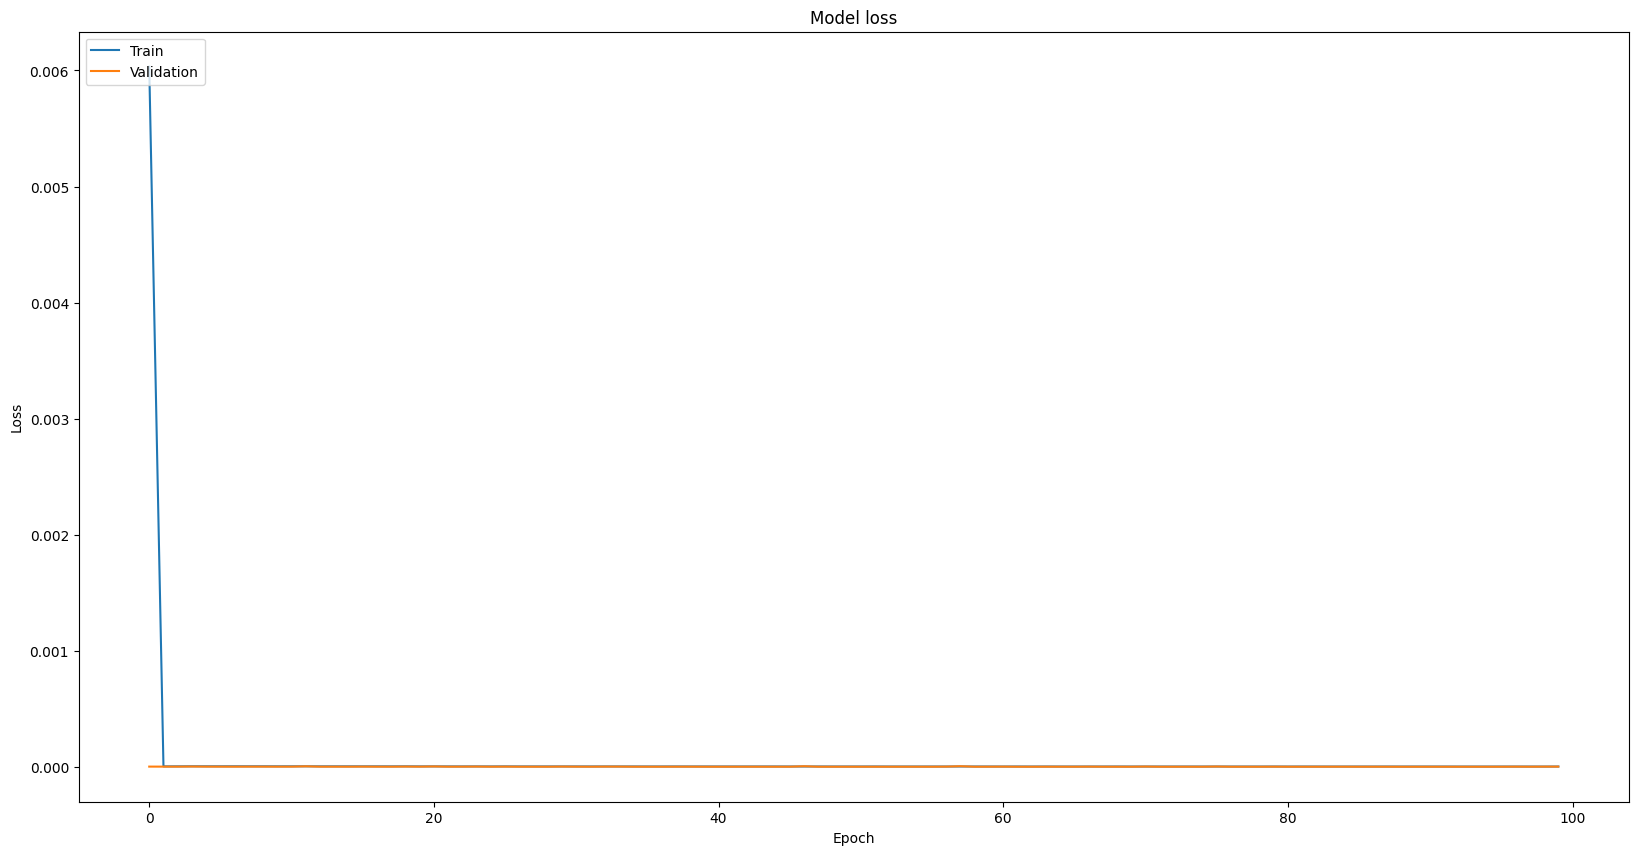

In [16]:
%matplotlib inline
plt.figure(figsize=(20,10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

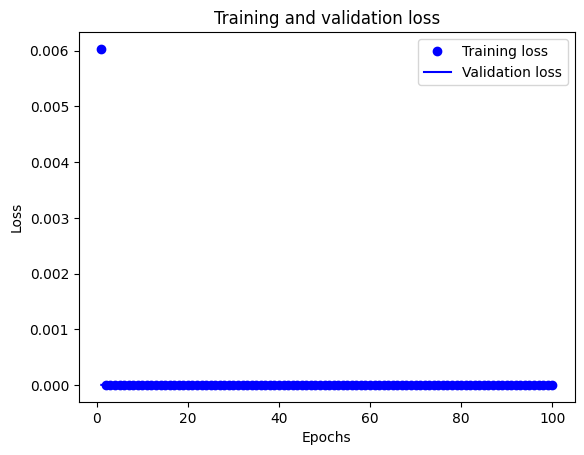

In [17]:

import matplotlib.pyplot as plt

# 학습과 검증 손실 추출
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# 손실 그래프 그리기
epochs = range(1, len(train_loss) + 1)
plt.plot(epochs, train_loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
with h5py.File(''.join(['./bitcoin2017to2023_close.h5']), 'r') as hf:
    datas = hf['inputs'][()]
    labels = hf['outputs'][()]
    input_times = hf['input_times'][()]
    output_times = hf['output_times'][()]
    original_inputs = hf['original_inputs'][()]
    original_outputs = hf['original_outputs'][()]
    original_datas = hf['original_datas'][()]

scaler=MinMaxScaler()
#split training validation
training_size = int(0.8* datas.shape[1])
training_datas = datas[:training_size,:,:]
training_labels = labels[:training_size,:,:]
validation_datas = datas[training_size:,:,:]
validation_labels = labels[training_size:,:,:]
validation_original_outputs = original_outputs[training_size:,:,:]
validation_original_inputs = original_inputs[training_size:,:,:]
validation_input_times = input_times[training_size:,:,:]
validation_output_times = output_times[training_size:,:,:]

ground_true = np.append(validation_original_inputs,validation_original_outputs, axis=1)
ground_true_times = np.append(validation_input_times,validation_output_times, axis=1)
step_size = datas.shape[1]
batch_size= 8
nb_features = datas.shape[2]

model = Sequential()

#build model
model = Sequential()
model.add(Conv1D(activation="relu", input_shape=(step_size, nb_features), strides=3	, filters=8, kernel_size=8))
# model.add(Dropout(0.05))
model.add(Conv1D( strides=4, padding='same', filters=nb_features, kernel_size=8))
model.add(LSTM(100, input_shape=(None, 1), activation='relu'))
model.add(Dense(1))

# 가중치 적용: weights에 생성된 적절한 가중치 선택
#model.load_weights('./weights_2017to2023/2017to2023_BTC-KRW-38-0.00000.hdf5')
#model.compile(loss='mse', optimizer='adam')

In [20]:
training_size

6

In [36]:
predicted = model.predict(validation_datas)
predicted_inverted = []

for i in range(original_datas.shape[1]):
    scaler.fit((np.char.replace((original_datas[:,i].astype(str)), ',', '').astype(float)).reshape(-1,1))
    predicted_inverted.append(scaler.inverse_transform(predicted[:,i].reshape(-1,1)))
print(np.array(predicted_inverted).shape)
#get only the close data
predicted_inverted = np.array(predicted_inverted).reshape(-1,original_datas.shape[1])[:,:4]

ground_true = ground_true.reshape(-1)
ground_true_times = ground_true_times.reshape(-1)
ground_true_times = pd.to_datetime(ground_true_times.astype(str), format="%Y-%m-%dT%H:%M:%S")
# since we are appending in the first dimension
predicted_inverted = np.array(predicted_inverted)[0,:,:].reshape(-1)

print(np.array(predicted_inverted).shape)
validation_output_times = pd.to_datetime(validation_output_times.astype(str).reshape(-1), format="%Y-%m-%dT%H:%M:%S")

2045/2045 [==============================] - 2s 789us/step
(1, 65423, 1)


ValueError: unconverted data remains when parsing with format "%Y-%m-%dT%H:%M:%S": ".000000000", at position 0. You might want to try:
    - passing `format` if your strings have a consistent format;
    - passing `format='ISO8601'` if your strings are all ISO8601 but not necessarily in exactly the same format;
    - passing `format='mixed'`, and the format will be inferred for each element individually. You might want to use `dayfirst` alongside this.

In [22]:
ground_true_df = pd.DataFrame()
ground_true_df['times'] = ground_true_times
ground_true_df['value'] = ground_true
ground_true_df

ValueError: Cannot set a frame with no defined index and a value that cannot be converted to a Series

In [151]:
ground_true_times

DatetimeIndex(['2023-05-09 14:05:00', '2023-05-09 14:00:00',
               '2023-05-09 13:55:00', '2023-05-09 13:50:00',
               '2023-05-09 13:45:00', '2023-05-09 13:40:00',
               '2023-05-09 13:35:00', '2023-05-09 13:30:00',
               '2023-05-09 13:25:00', '2023-05-09 13:20:00',
               ...
               '2017-09-25 12:55:00', '2017-09-25 12:50:00',
               '2017-09-25 12:45:00', '2017-09-25 12:40:00',
               '2017-09-25 12:35:00', '2017-09-25 12:30:00',
               '2017-09-25 12:25:00', '2017-09-25 12:20:00',
               '2017-09-25 12:15:00', '2017-09-25 12:10:00'],
              dtype='datetime64[ns]', length=588861, freq=None)

In [152]:
prediction_df = pd.DataFrame()
prediction_df['times'] = validation_output_times
prediction_df['value'] = predicted_inverted
prediction_df

,times,value
0,2023-05-09 13:25:00,37053316.0
1,2023-05-09 12:40:00,37092540.0
2,2023-05-09 11:55:00,37114500.0
3,2023-05-09 11:10:00,37170420.0
4,2023-05-09 10:25:00,37262684.0
...,...,...
65424,2017-09-25 21:40:00,4229080.0
65425,2017-09-25 20:55:00,4206210.5
65426,2017-09-25 20:10:00,4201295.5
65427,2017-09-25 12:55:00,4245097.0


In [30]:
%matplotlib inline
plt.figure(figsize=(50,25))
plt.plot(ground_true_df.times,ground_true_df.value, label = 'Actual')
plt.plot(prediction_df.times, prediction_df.value, 'o', markersize=3, label='Predicted')
plt.legend(loc='upper left')
plt.show()

AttributeError: 'DataFrame' object has no attribute 'times'

<Figure size 5000x2500 with 0 Axes>